# Import Cell

In [7]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from src_folder import src as functions
%load_ext autoreload
%autoreload 2
import re
from wordcloud import WordCloud
from nltk.tokenize import regexp_tokenize, word_tokenize, sent_tokenize
from sklearn.model_selection import train_test_split, cross_validate , GridSearchCV, cross_val_predict
from sklearn.pipeline import make_pipeline , Pipeline
from nltk import word_tokenize
from nltk.corpus import stopwords as sw
from sklearn.linear_model import LogisticRegression , SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import warnings
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline as imbpipe
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
warnings.filterwarnings ("ignore")
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from nltk.stem import SnowballStemmer
from sklearn.metrics import plot_confusion_matrix
from sklearn.cluster import KMeans

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# EDA

In [8]:
df = pd.read_csv('data/Labelled Yelp Dataset Edited.csv')
target = len(df.loc[df['Label'] == -1])
not_target = len(df.loc[df['Label'] == 1])
pd.set_option ('display.max_colwidth', None)         

In [9]:
print(f'''Number of targets: {target}
Percent of data target: {round(target / len(df),3)*100}
Number of rows: {len(df)}''')

Number of targets: 11154
Percent of data target: 10.0
Number of rows: 111798


There are 11154 fake reviews that make up 10 percent of the data. If we were to go ahead and classify everything as a real review, there would be a 90% accuracy rate. 

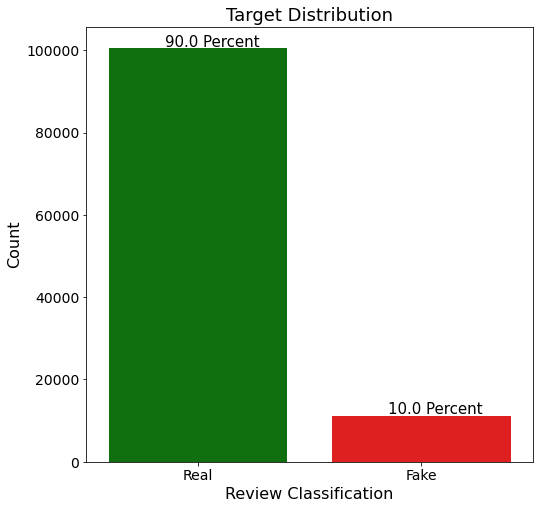

In [10]:
fig , ax = plt.subplots(figsize=(8,8))

sns.barplot(x=['Real','Fake'],y=[not_target,target],palette=['green','red'])
plt.text(0-.15,not_target+300,f'{round(not_target/(len(df)),2)*100} Percent',fontsize=15)
plt.text(1-.15,target+500,f'{round(target/(len(df)),2)*100} Percent',fontsize=15)
ax.set_title('Target Distribution',fontsize=18)
ax.set_xlabel('Review Classification',fontsize=16)
ax.set_ylabel('Count',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('images/Target_Distribution');

In [11]:
pd.to_datetime(df['Date'])
df['Date'].sort_values(ascending=False)

89577    9/9/2014
89980    9/9/2014
73459    9/9/2014
73277    9/9/2014
98882    9/9/2014
           ...   
12723    1/1/2009
32351    1/1/2009
74463    1/1/2009
67654    1/1/2008
4100     1/1/2008
Name: Date, Length: 111798, dtype: object

Here I check to see the range of data I am working with. 2008-2014.

In [12]:
df.isna().sum()

User_id       0
Product_id    0
Rating        0
Date          0
Review        0
Label         0
dtype: int64

There are no null values in our data set.

In [13]:
df.loc[df['Label'] == -1].tail(20)

,User_id,Product_id,Rating,Date,Review,Label
111331,69314,54,5,5/6/2013,"The best restaraunt in New York City and one of the most historical places. I come here a lot. I love to support them instead of supporting other restaraunts in manhattan. It's my favorite, great food, great service, and most of all its a revolutionary war place which is my favorite! I can't believe George Washington slept, ate, and stayed here during the 1700s ! Bowling green is nearby which is a nice historical park, as well as other revolutionary war sites you should, visit. I live nearby on Chambers St and come here a lot to support them. Please support them the. Money goes to great cause. Museum is the best upstairs too.",-1
111332,69315,54,5,3/31/2013,"The bar is such a great spot and has so much character! Over 100 some beers from $6-$12 bucks, Â and the food is great too. The shepherds pie is AMAZING and comes in a pan!!",-1
111333,69316,54,5,1/2/2013,The best place to have a beer and a bite. They have hundreds of different kinds of beers.,-1
111334,69317,54,5,11/6/2011,I never even heard of this place before signing up for the Zombies vs Vampires Halloween Scavenger Hunt but now that I know about I will be back! First of all it's like a restaurant and brew pub and sports bar and museum all wrapped into 1. The place is HUGE! The prices are cheap and there's enough room so you're not super crowded or packed in. Before the scavenger hunt I was in the back bat watching the series game and having a beer. The bartender (who was hot) was awesome! The French fries at this place are sick! I got 2 orders they were SO good! And George Washington drank here! It's totally true! I like Stone Street a lot and this is a couple blocks away and it's really worth going to. It's cool to go with friends or to hang out or even on a date. Plus they had this place as the starting point and the after party place for Zombies vs Vampires (zombiesVvampires.com if u want to check it out). Such a cool place! Laid back! Not expensive! Pretty easy to get to on the 1. I wish I knew about it before. You definitely have to try this place out.,-1
111335,69318,54,5,10/14/2011,"I've been here twice now and I'm a huge fan of their food and beer. Their porter is smooth, creamy and very, very tasty. In my opinion, it's better than Guinness. It's worth going there just for the beer. The first time I went was in the evening. Their bar food was exceptional. Their fish and chips are solid, and I liked a mushroom based vegetarian dish. I've forgotten what they're called, but you should definitely their mini-sausages wrapped in dough. In the evenings though, it can get crowded and it's hard to get your waiter's attention. My girlfriend was lucky to win a free lunch there. Their potato and leek soup was sublime and their bangers and mash were very good too. The servers are very nice and helpful and I highly recommend the place.",-1
111644,69460,60,2,1/20/2014,"First off, I would like to be upfront and say that the food is quote good and full of flavor. However the biggest thing that irked me was the size of their platters. The are in that awkward place between the size/price of an appetizer and the size/price of a normal main dish platter. In a regular restaurant I would maybe spend $10 on an appetizer and $20 on a main dish, and this is if I am feeling particularly hungry. Here I literally had to get two ""main dishes"" which amounted to about $35 and still left fairly hungry. If you just want an expensive but flavorful snack, this place is good. But if you are looking for a place to eat this may not be the best value. The interior is also a bit strange. It tried to pull off the ambiance of a restaurant with candles and a darkly lit setting, but the white plastic bar tables are strangely positioned and are cold in nature. Bottom line, the chef is great and the ideas behind the dishes are wonderful. But unless this place changes its value proposition it will not last long. Suggestion - keep th

Here I look at how some of the fake or disingenuous reviews are worded. They all seem real to me, I must be missing something. I also wonder how or why they were rated genuine or not. Was it a person who did this? I could not find the answer on kaggle, I will assume the data is accurate and continue to go with it. 

After doing a little more research, I found out that Yelp also classifies them as 'recommended' or 'not recommended'. https://www.reviewtrackers.com/blog/fake-yelp-reviews/ is the website I discovered this at. Each post is carefully vetted by employees at Yelp. At the current state of that article(Jan 2019), 70% are recommended while 30% are not. Rants are put in the non recommended, along with those that seem solicitated. They want all reviews to be genuine, without a restaraunt trying to boost their ratings in a disingenuous manner. Yelp also has more information such as which computers the reviews came from and activity of the users.

https://www.youtube.com/watch?v=KdG81QKdga0 is a link to a video where 5 star reviews are sold to businesses. There are Facebook groups where you can go to find people who will boost your score, with the 'elite' reviews being premium since they cannot be removed. This video is from September of 2020. This is why the fake reviews are so hard to spot. They are actual people writing these for money boosting the business rating. This leads to the question, can you also pay a group of people to bring down a competing business?

https://money.cnn.com/2014/09/24/smallbusiness/purposefully-bad-yelp-reviews/index.html is a story about a man in Richmond,California who offered 25% off of his pizza for NEGATIVE reviews. This was done as a publicity stunt for the restaurant and increased traffic.

In [14]:
df.loc[df['Label'] == 1].tail(20)

,User_id,Product_id,Rating,Date,Review,Label
111778,69545,318,5,12/20/2013,"Excellent southern delivery!! I had chicken wings and red velvet waffles with delicious greens. My husband had oxtails and said they were great, albeit a bit salty. I'm definitely ordering again!",1
111779,69546,318,5,11/21/2013,Oh....and BEST WAFFLES in Brooklyn - I MEAN THAT....Try them for breakfast as well,1
111780,69547,318,5,11/20/2013,This place had the best chicken and waffles...as well as other genuine down home cuisine with a nice simple decor that makes a country boy like me feel right at home...I'd your looking for a good meal and to replace the new York attitude for a little southern hospitality check this spot out,1
111781,69548,318,2,11/1/2013,Yelpers you steered me wrong... I got excited reading the reviews because Napoleon is not far from my house. So rushed from work to get her and the food was beyond disappointing. I had the fried fish mac and cheese and the collards. Fish under cooked and bland...I didn't taste an ounce of seasoning I had to use the tarter sauce for that. Mac and cheese I can't put my finger on the cheese but it taste powdery like Â a combination of kraft mac and cheese with real cheese added for good measure. Colards wouldn't have been bad if they weren't salty The young lady said she knew I would come back...I think not. I could have had end if the day food and theres a chance it may be better during regular hours...but I don't want to find out.,1
111782,69549,318,5,10/12/2013,"I don't think that I will be going back for the rest of the year. Here's why: THE FOOD IS TOO GOOD!!!!!!!!! Do you understand what that means? THE F-O-O-D is G-O-O-D! I went into the store because earlier that day, I was CRAVING for some chicken and waffles. I went on yelp because I was going to go to Sweet Chick to test it out, but I work all the way in the Bronx and when I'm off, I don't like traveling and Williamsburg was a stretch from Crown Heights that day. I'm sorry. I see this place on Yelp that's right around the corner so I take the bus and I'm on the hunt. I go into the store that is EXTREMELY clean. I tell the guy that I want the red velvet waffles and chicken wings plus the sweet tea and a side of macaroni and cheese. I have a seat, drooling with anticipation. I almost cried when he set the food in front of me. The red velvet waffle had a sweet cream cheese glaze and it was so good. I asked for syrup on the side, but it wasn't needed. Not too sweet, but it was good. It was just right. BEST WAFFLE I EVER HAD IN MY LIFE! And trust me, I know my way around waffles. Damn a pancakes and DAMN a French toast! I had to order a second waffle. I also had a homemade half and half and It was the best I've ever had in New York State. (Just needs some Jack Daniel's Honey to mix with!) Come to find out that the guy that was serving me was the owner! I LOVE to see a business where the owner is hands on. Just a pleasant and humble person. Respect will get you places money won't. Because the owner is a humble man, his restaurant will flourish. I pray this is so, he deserves it. And he's from Birmingham, AL! It shows in his cooking. Â I wanted to try the banana pudding that was in the window but I didn't have the space. Maybe next year. Fuck am I kidding? I'm cancelling the NYSC membership and I'm at Napoleon's TOMORROW!!!!!! Love and life.",1
111783,69550,318,5,10/6/2013,"Red velvet waffles with chicken wings. Don't order anything else, it's incredible!",1
111784,16438,318,3,9/15/2013,"I look forward to updating this review to give it a better rating because the food (for the most part) was good! Unfortunately, it took them 2 hours to deliver the food when they originally estimated 35-45 mins, that knocked down the 4th star. The chicken was DARN good! We'll skip the fries next time, they were super soggy and greasy with a slice of american cheese melted on top. Unfortunately we couldn't tell if the red velvet waffle was good or not, it sweated o

Here I look at how the real reviews are worded. I find them worded similarly to the fake reviews so now I am certain I must be missing something. Hopefully the model can pick up on something I can't.

In [15]:
# Apply function that adds the columns Number of Words, Character Review Length,Sentences,Sentence Count, Avg Words Per Sentence to DataFrame
df_engineered = functions.transform(df,'Review')

Avg Review: 655.3
Avg Fake Review: 459.37
Avg Real Review: 677.01


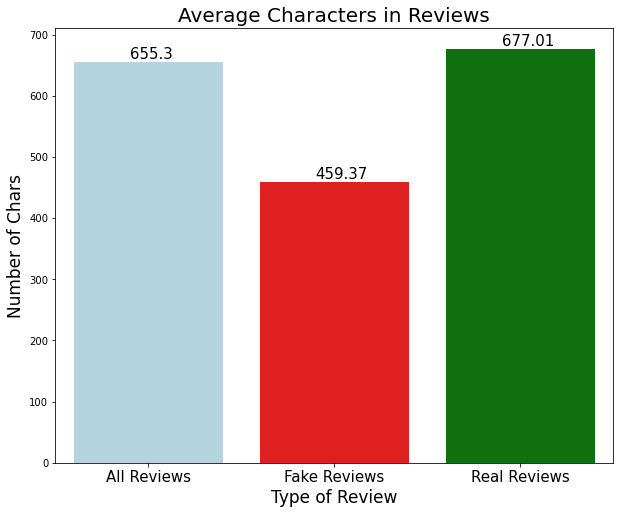

In [16]:
functions.word_stats(df_engineered,'Character Review Length',xlabel='Type of Review',ylabel='Number of Chars',title='Average Characters in Reviews',up_down=5,left_right=.1)

This is interesting, the fake reviews are noticably shorter than reviews deemed as real. This is based off of character count, let's look at word count.

Avg Review: 119.72
Avg Fake Review: 84.03
Avg Real Review: 123.68


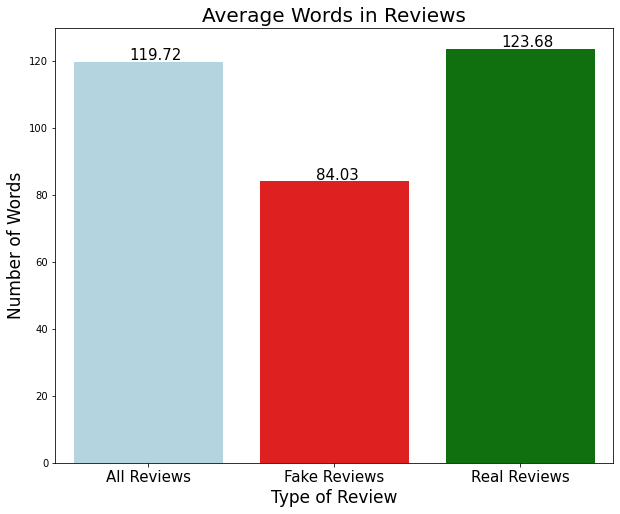

In [17]:
functions.word_stats(df_engineered,'Number of Words',xlabel='Type of Review',ylabel='Number of Words',title='Average Words in Reviews',up_down=.5,left_right=.1)

Again, the average words for the fake reviews are much lower than that of real reviews.

Avg Review: 8.67
Avg Fake Review: 6.31
Avg Real Review: 8.93


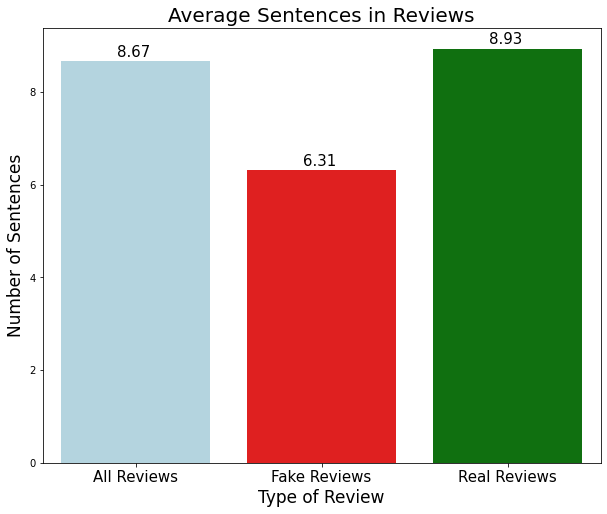

In [18]:
functions.word_stats(df_engineered,'Sentence Count',xlabel='Type of Review',ylabel='Number of Sentences',title='Average Sentences in Reviews',left_right=.1,up_down=.1)

So again, the fake reviews have less sentences on average.

In [19]:
num_sentlength_reviews = sum(df_engineered['Sentence Count'])
num_sentlength_fakereviews = sum(df_engineered.loc[df_engineered['Label'] == -1]['Sentence Count'])
num_sentlength_realreviews = sum(df_engineered.loc[df_engineered['Label'] == 1]['Sentence Count'])

avg_chars_sentence = round(sum(df_engineered['Character Review Length'])/num_sentlength_reviews,2)
avg_chars_fake_sentence = round(sum(df_engineered.loc[df_engineered['Label'] == -1]['Character Review Length'])/num_sentlength_fakereviews,2)
avg_chars_real_sentence = round(sum(df_engineered.loc[df_engineered['Label'] == 1]['Character Review Length'])/num_sentlength_realreviews,2)

In [20]:
print(f'''Avg Character Length Sentences: {avg_chars_sentence}
Avg Fake Review Character Length Sentences: {avg_chars_fake_sentence}
Avg Real Review Character Length Sentences: {avg_chars_real_sentence}
''')

Avg Character Length Sentences: 75.56
Avg Fake Review Character Length Sentences: 72.79
Avg Real Review Character Length Sentences: 75.77



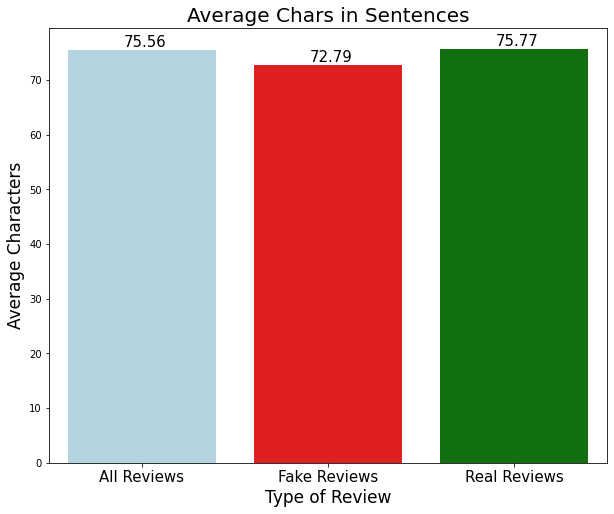

In [21]:
fig , ax = plt.subplots(figsize=(10,8))
x= ['All Reviews', 'Fake Reviews','Real Reviews']
y=[avg_chars_sentence,avg_chars_fake_sentence,avg_chars_real_sentence]

sns.barplot(x=['All Reviews', 'Fake Reviews','Real Reviews'],y=y,palette=['lightblue','red','green'])
ax.set_title('Average Chars in Sentences',fontsize=20)
functions.addlabels(x,y,.1,.5,font=15)
ax.set_ylabel('Average Characters',fontsize=17)
ax.set_xlabel('Type of Review',fontsize=17)
plt.xticks(fontsize=15);

Here we have a case where there is not as big as a discrepancy. The average characters in the sentences are about the same.The character count for the fake reviews are a little bit shorter, but not by much.

In [22]:
df_engineered['Avg Words Per Sentence'] = df_engineered['Number of Words'] / df_engineered['Sentence Count']
avg_word_sentence = df_engineered['Avg Words Per Sentence'].mean()
avg_word_fakereview = df_engineered.loc[df_engineered['Label'] == -1]['Avg Words Per Sentence'].mean() 
avg_word_realreview = df_engineered.loc[df_engineered['Label'] == 1]['Avg Words Per Sentence'].mean() 

In [23]:
print(f'''Avg Word in Sentences: {round(avg_word_sentence,2)}
Avg Fake Review Word in Sentences: {round(avg_word_fakereview,2)}
Avg Real Review Word in Sentences: {round(avg_word_realreview,2)}
''')

Avg Word in Sentences: 13.57
Avg Fake Review Word in Sentences: 12.87
Avg Real Review Word in Sentences: 13.64



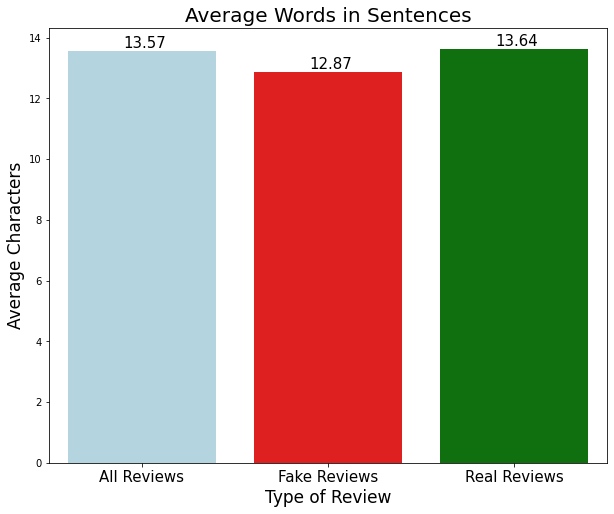

In [24]:
fig , ax = plt.subplots(figsize=(10,8))
x= ['All Reviews', 'Fake Reviews','Real Reviews']
y=[round(avg_word_sentence,2),round(avg_word_fakereview,2),round(avg_word_realreview,2)]

sns.barplot(x=['All Reviews', 'Fake Reviews','Real Reviews'],y=y,palette=['lightblue','red','green'])
ax.set_title('Average Words in Sentences',fontsize=20)
functions.addlabels(x,y,.1,.1,font=15)
ax.set_ylabel('Average Characters',fontsize=17)
ax.set_xlabel('Type of Review',fontsize=17)
plt.xticks(fontsize=15)
plt.savefig('images/Avg_Char_Sent');

Once again the fake reviews are shorter than the real reviews, but there is not a huge discrepancy in the average words in the sentences.

So overall, the fake reviews are shorter in general. Some things can be added to the model to help pick up on this. 

# Further EDA

Here I just want to take a look at a couple of more things about the data. I am curious about the words that fall into both fake and real reviews, while also wondering if there are any words that only appear in real reviews that do not appear in fake reviews.

In [81]:
# Perform some cleaning and more tokenizing of the reviews while removing numbers and puncuation
df_engineered['Clean'] = df_engineered['Review'].str.replace(r'[^\w\s]', '')
df_engineered['Clean'] = df_engineered['Clean'].str.lower()
df_engineered['Clean'] = df_engineered['Clean'].str.replace('\d+', '')
df_engineered['Clean Tokens'] = df_engineered['Clean'].str.split(' ')

In [84]:
# Split the data into real review DF and fake review DF
df_fake = df_engineered.loc[df_engineered['Label'] == -1]
df_real = df_engineered.loc[df_engineered['Label'] == 1]

In [85]:
raw_real = []
raw_fake = []

#Putting the tokens from the fake reviews DF into a list
for listx in df_fake['Clean Tokens']:
    for x in listx:
        raw_fake.append(x)
# Putting tokens from the real reviews DF into a list
for col in df_real['Clean Tokens']:
    for y in col:
        raw_real.append(y)        

In [87]:
clean_real = []
clean_fake = []

# Here we take out stop words in both lists
for x in raw_fake:
    if x not in sw.words('english'):
        clean_fake.append(x)

for i in raw_real:
    if i not in sw.words('english'):
        clean_real.append(i)

In [88]:
# Create word count for fake and real reviews
counts_fake={}
for i in clean_fake:
    counts_fake[i] = counts_fake.get(i, 0) + 1
fake_sorted = dict(sorted(counts_fake.items(), key=lambda item: item[1],reverse=True))

counts_real = {}
for i in clean_real:
    counts_real[i] = counts_real.get(i, 0) + 1
real_sorted = dict(sorted(counts_real.items(), key=lambda item: item[1],reverse=True))

In [89]:
# Clean some values
for x in ['','â\xa0the','â\xa0','â\xa0i']:
    real_sorted.pop(x)
    fake_sorted.pop(x)

In [90]:
# This cell takes out unique words to real and fake reviews
unique_real = []
unique_fake = []

for word in clean_real:
    if word not in clean_fake:
        unique_real.append(word)
        
for word in clean_fake:
    if word not in clean_real:
        unique_fake.append(word)

In [91]:
# This creates two dictionaries containing the count of unique words in real and fake reviews
counts_unique_fake={}
for i in unique_fake:
    counts_unique_fake[i] = counts_unique_fake.get(i, 0) + 1
fake_unique_sorted = dict(sorted(counts_unique_fake.items(), key=lambda item: item[1],reverse=True))

counts_unique_real = {}
for i in unique_real:
    counts_unique_real[i] = counts_unique_real.get(i, 0) + 1
real_unique_sorted = dict(sorted(counts_unique_real.items(), key=lambda item: item[1],reverse=True))

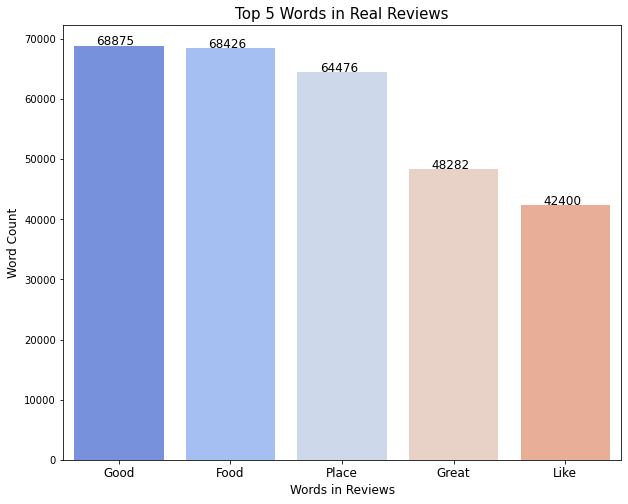

In [108]:
# Visual Representation of top 5 words in real reviews
fig , ax = plt.subplots(figsize=(10,8))

sns.barplot(x=list(real_sorted.keys())[:5],y=list(real_sorted.values())[:5],palette=sns.color_palette('coolwarm'))
functions.addlabels(list(real_sorted.keys())[:5],list(real_sorted.values())[:5],.2,100,font=12)
ax.set_title('Top 5 Words in Real Reviews',fontsize=15)
ax.set_xlabel('Words in Reviews',fontsize=12)
ax.set_ylabel('Word Count',fontsize=12)
plt.xticks([0,1,2,3,4],['Good','Food','Place','Great','Like'],fontsize=12);

These are the top 5 words that are in real reviews that are not unique to real reviews. Good food are the two most common words, probably coming in that order in the reviews.

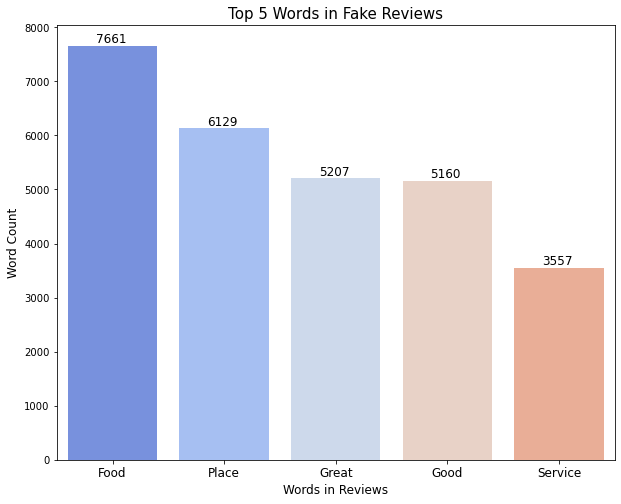

In [109]:
# Visual Representation of top 5 words in fake reviews
fig , ax = plt.subplots(figsize=(10,8))

sns.set_palette('coolwarm')
sns.barplot(x=list(fake_sorted.keys())[:5],y=list(fake_sorted.values())[:5])
functions.addlabels(list(fake_sorted.keys())[:5],list(fake_sorted.values())[:5],.15,50,font=12)
ax.set_title('Top 5 Words in Fake Reviews',fontsize=15)
ax.set_xlabel('Words in Reviews',fontsize=12)
ax.set_ylabel('Word Count',fontsize=12)
plt.xticks([0,1,2,3,4],['Food','Place','Great','Good','Service'],fontsize=12);

These are the top 5 words that appear in fake reviews not unique to fake reviews. I find it fascinating that good falls to fourth in this graph and is topped by great. In the real review top 5, good is the most mentioned word. I think great is used more in the fake reviews because they are trying to sell you on their review rather than focus on being authentic. Also service breaks in the top 5 here, because service is another term you can throw in for any review for a restaurant. There is not much thought putting the service was great in a review. 

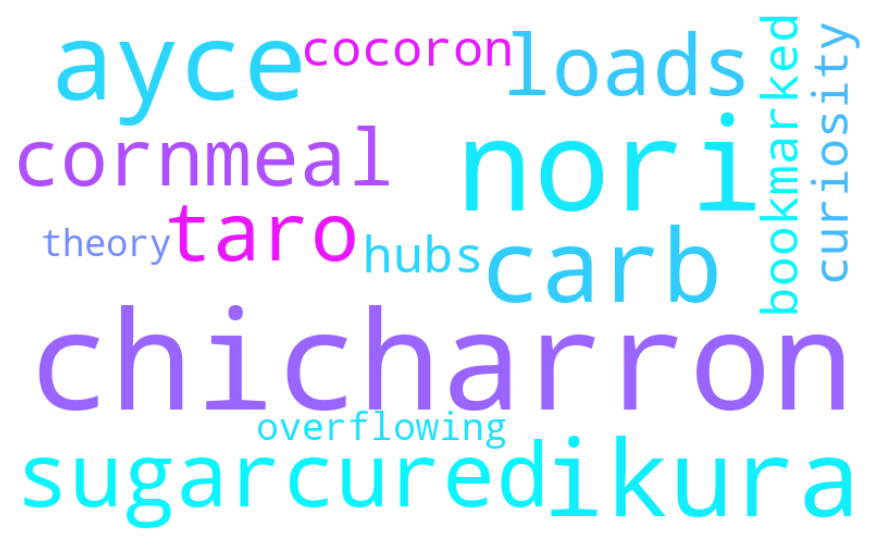

In [110]:
# Create a wordcloud of words found in real reviews
wc_real = WordCloud(background_color="white",width=800,height=500, max_words=15,relative_scaling=0.8,normalize_plurals=False, colormap = 'cool').generate_from_frequencies(real_unique_sorted)
plt.figure( figsize=(20,10) )
plt.imshow(wc_real, interpolation='bilinear')
plt.axis("off");

These are words from real reviews that do not show up in fake reviews. To my surprise, these are all real words. 'Chicharrón is a dish generally consisting of fried pork belly or fried pork rinds. Chicharrón may also be made from chicken, mutton or beef.'. I originally thought this was not a real word. Nori is seaweed, ayce stands for all you can eat. Ikura is red caviar. Cocoron is 'Soba Noodle, Ramen and Alternative Japanese Curry'. 

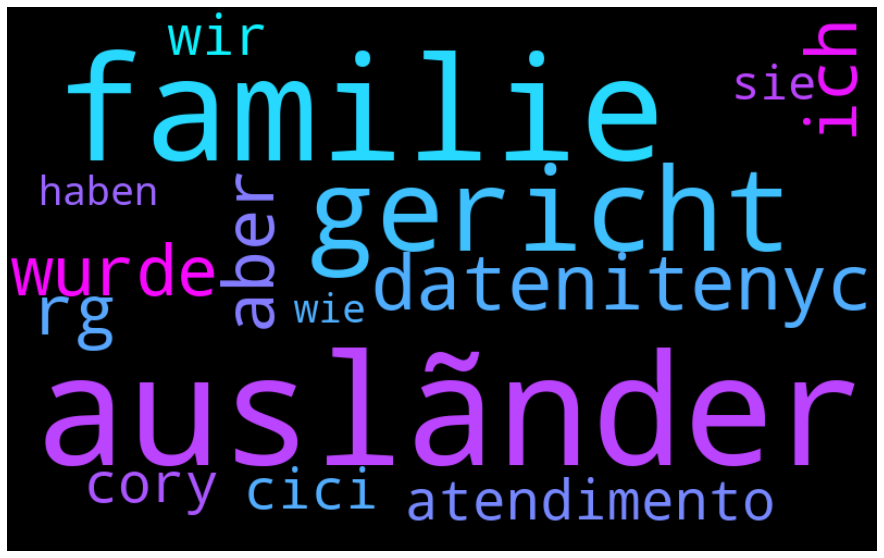

In [111]:
#Create word cloud of words found only in fake reviews
wc_fake = WordCloud(background_color="black",width=800,height=500, max_words=15,relative_scaling=0.8,normalize_plurals=False, colormap = 'cool').generate_from_frequencies(fake_unique_sorted)
plt.figure( figsize=(20,10) )
plt.imshow(wc_fake, interpolation='bilinear')
plt.axis("off");

These are words that show up only in fake reviews. Not to my surprise, most of the words are foreign. They seem to be mostly German actually. datenitenyc also appeared in there.

# Best Model

Please note that the iterative modelling process can be found in the Model NB under working notebooks.

## TFIDF Vectorizer with Logistic Regression

In [137]:
# Relabel our targets to a traditional 0 1 label
binary_dict = {1:0,-1:1}
df['Label'] = df['Label'].map(binary_dict)

In [142]:
X = functions.test_df(df_engineered,'Review')
y = df['Label']

In [143]:
#Perform train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

In [144]:
# params for LR model
params = {'LR__C':[.05,.01,.1,1,5],
         'LR__solver':['lbfgs', 'liblinear', 'sag','saga'],
         'LR__class_weight':[None,'balanced',.25,.5,.75]}

In [145]:
# Tell TFIDF which column to vectorize
column_transformer = ColumnTransformer(
    [('tfidf1', TfidfVectorizer(stop_words=sw.words('english')), 'sentence')], 
    remainder='passthrough')

# fit the model
final_log_eng_model = imbpipe(steps=[('tfidf1', column_transformer),
                                     ('under',RandomUnderSampler('majority',random_state=42)),
                                     ('LR',LogisticRegression())])
# Evaluate results     
final_log_eng_results = cross_validate(final_log_eng_model,X_train,y_train,return_train_score=True,scoring='recall')
functions.mean_scores(final_log_eng_results)

Mean Train Score: 0.6980103226256883
Mean Test Score: 0.6670238041678183


In [146]:
# Perform the GS
lr_final = GridSearchCV(final_log_eng_model,params,return_train_score=True,scoring='recall')
lr_final.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidf1',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('tfidf1',
                                                                         TfidfVectorizer(stop_words=['i',
                                                                                                     'me',
                                                                                                     'my',
                                                                                                     'myself',
                                                                                                     'we',
                                                                                                     'our',
                                                                                                     'ours',
                             

In [147]:
# metrics for the model
lr_final_ypreds = cross_val_predict(lr_final.best_estimator_, X_train,y_train)
functions.metrics(y_train,lr_final_ypreds)

Recall Score: 0.718656627226007
Precision Score: 0.1576849447984685
Accuracy Score:0.5888512546512737
F1 Score: 0.25862365591397846
Confusion Matrix: 
[[43361 32120]
 [ 2354  6013]]


In [148]:
#Cleans up GS param dictionary to unpack it
param_dict = {x.replace("LR__", ""): v for x, v in lr_final.best_params_.items()}
param_dict

{'C': 0.05, 'class_weight': None, 'solver': 'liblinear'}

In [149]:
# Tell TFIDF which column to vectorize
column_transformer = ColumnTransformer(
    [('tfidf1', TfidfVectorizer(stop_words=sw.words('english')), 'sentence')], 
    remainder='passthrough')

# fit the model with the best parameters
final_log_eng_model = imbpipe(steps=[('tfidf1', column_transformer),
                                     ('under',RandomUnderSampler('majority',random_state=42)),
                                     ('LR',LogisticRegression(**param_dict))])
# Evaluate results     
final_log_eng_results = cross_validate(final_log_eng_model,X_train,y_train,return_train_score=True,scoring='recall')
functions.mean_scores(final_log_eng_results)

Mean Train Score: 0.7344925384587466
Mean Test Score: 0.7186556318962851


In [155]:
functions.metrics(y_test,final_log_eng_model.predict(X_test))

Recall Score: 0.6925008970218873
Precision Score: 0.15697437982919887
Accuracy Score:0.5984973166368516
F1 Score: 0.255934226229943
Confusion Matrix: 
[[14798 10365]
 [  857  1930]]


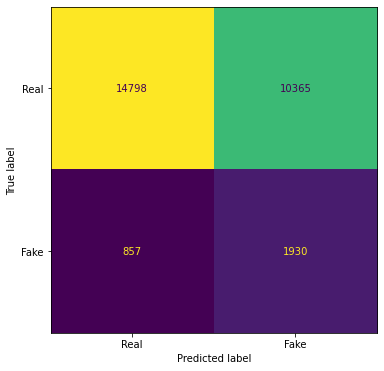

In [153]:
# Confusion matrix on Test set
fig , ax = plt.subplots(figsize=(8,6))
plot_confusion_matrix(final_log_eng_model,X_test,y_test,display_labels=['Real','Fake'],colorbar=False,ax=ax,values_format='d');

While the model does a good job at catching most of the fake reviews, there are alot of false positives that could be improved with this model.

# Model on Local Reviews

In [156]:
# Open all of our scraped data frames and combine them into one
file = open('data/scraped_data/Broaddus_df','rb')
df_Broaddus = pickle.load(file)
file.close()

file = open('data/scraped_data/BonTemps_df','rb')
df_BonTemps = pickle.load(file)
file.close()

file = open('data/scraped_data/ruffinos_df','rb')
df_ruffinos = pickle.load(file)
file.close()

file = open('data/scraped_data/social_df','rb')
df_social = pickle.load(file)
file.close()
# Put together as one
scraped_df = pd.concat([df_Broaddus,df_BonTemps,df_ruffinos,df_social],ignore_index=True)

In [157]:
# These are reviews scraped from the not recommended section, which we will combine to our main data frame
file = open('data/scraped_data/BonTemps_NR_review','rb')
df_nr_bontemps = pickle.load(file)
file.close()

file = open('data/scraped_data/broaddus_NR_review','rb')
df_nr_broaddus = pickle.load(file)
file.close()

file = open('data/scraped_data/ruffino_NR_reviews','rb')
df_nr_ruffino = pickle.load(file)
file.close()

nr_scraped = pd.concat([df_nr_bontemps, df_nr_broaddus,df_nr_ruffino])
scraped_reviews_all = pd.concat([nr_scraped,scraped_df],ignore_index=True)

In [190]:
# Total reviews scraped from yelp
len(scraped_reviews_all)

1819

In [198]:
# Get the scraped data ready for predictions
scraped_test = functions.transform(scraped_reviews_all,'review')
test = functions.test_df(scraped_test,'review')

In [164]:
# Predict to see what reviews will be
y_preds_scraped = final_log_eng_model.predict(test)

In [166]:
# Put the labels to prediction
scraped_reviews_all['Label'] = pd.Series(y_preds_scraped)

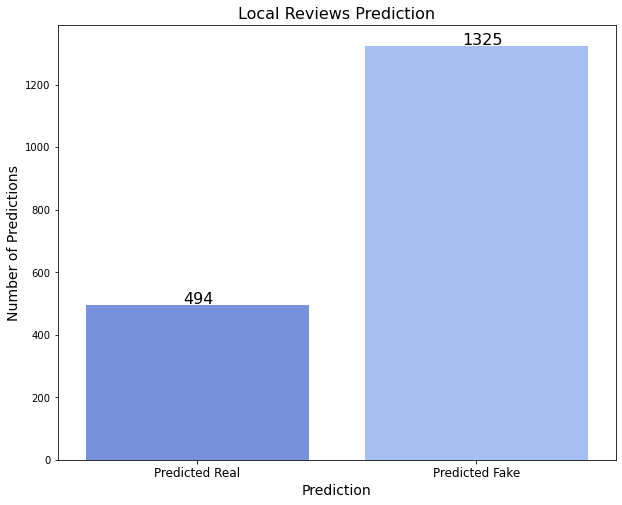

In [191]:
fig , ax = plt.subplots(figsize=(10,8))
x = ['Predicted Real','Predicted Fake']
y = [len(scraped_reviews_all.loc[scraped_reviews_all['Label'] == 0]), len(scraped_reviews_all.loc[scraped_reviews_all['Label'] == 1])]

sns.barplot(x=x,y=y)
ax.set_title('Local Reviews Prediction',fontsize=16)
plt.xticks(fontsize=12)
ax.set_xlabel('Prediction',fontsize=14)
ax.set_ylabel('Number of Predictions',fontsize=14)
functions.addlabels(x,y,.05,4,font=16)


The model predicts most of the reviews I scraped to not be real. I know the model does have a problem with false positives, but perhaps my local area is full of fake review troll accounts also?